# 参考資料

- [Python: 時系列データの交差検証と TimeSeriesSplit の改良について](https://blog.amedama.jp/entry/time-series-cv)
- [Time Series Nested Cross-Validation](https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9)

# Environment

## Libraries

In [31]:
import sys

sys.path.append("../")
import logging
from calendar import month_name

import lightgbm as lgb
import pandas as pd
import seaborn as sns
from datamart import Datamart
from feature import Feature
from matplotlib import pyplot as plt
from name import Name
from pandas.plotting import register_matplotlib_converters
from raw_data import RawData
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from symbol_data import SymbolData

register_matplotlib_converters()

## Log Level

In [41]:
from logging import INFO, getLogger

logger = getLogger(__name__)
logger.setLevel(INFO)
logger.info("message")

INFO:__main__:message


## Functions & Classes

In [114]:
def create_datamart(
    ticker: str,
    num_lag: int = 5,
    days_before: int = 1,
    single_values: str = "close",
    nation: str = "US",
) -> pd.DataFrame:
    """データマートを生成する。"""
    name = Name(ticker, nation)
    ticker = name.ticker
    symbol_data = SymbolData(ticker).symbol_data
    raw_data = RawData(symbol_data).raw_data
    return Datamart(raw_data, single_values, num_lag, days_before, ticker).datamart


def helper_lineplot(idx: int, label: str, axes):
    """viz_train_test内で使用するヘルパー関数"""
    sns.lineplot(
        data=data.iloc[idx],
        x=date_time,
        y=target,
        ax=axes,
        label=label,
    )


def viz_train_test(data: pd.DataFrame, date_time: str, target: str):
    """学習用のデータとテスト用のデータに分割するためのインデックス情報を得る"""
    # データの並び順を元に分割する
    folds = TimeSeriesSplit(n_splits=5)

    for i, (train_index, test_index) in enumerate(folds.split(data)):
        fig, axes = plt.subplots(1, 1, figsize=(12, 6))
        # 元のデータを描く
        helper_lineplot(data.index, "orig", axes)
        # 学習用データを描く
        helper_lineplot(train_index, "train", axes)
        # テスト用データを描く
        helper_lineplot(test_index, "test", axes)
        # グラフを表示する
        plt.legend()
        plt.show()
        # 生のインデックス
        print(f"index of train: {train_index}")
        print(f"index of test: {test_index}")
        print("----------")

In [127]:
class ModelTimeSeries:
    """Model class predicts future price, up or down.
    Use LightGBM as a predictor model.
    Args:
        datamart: the stock datamart you want to predict
        feature: explanatory variables
    """

    def __init__(self, datamart, feature):
        self._datamart = datamart
        self._feature = feature

    @property
    def _df(self):
        _df = pd.concat([self._datamart, self._feature], axis=1)
        _df.index = pd.to_datetime(_df.index, unit="ms")
        logger.info(f"dropna before share:{_df.shape}")
        # TODO: ここで欠損はないはず
        _df = _df.dropna()
        logger.info(f"dropna before share:{_df.shape}")
        return _df

    @property
    def _X(self):
        # TODO: 予測対象日の株価は特徴量として使用しない
        col = [_col for _col in self._df.columns if "N-0" not in _col]
        col.remove("target")
        return self._df[col]

    @property
    def _y(self):
        return self._df["target"]

    def _train_test_split(self):
        # WARNING: wrong description. Don't use this desc.
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self._X, self._y, test_size=0.3, random_state=0
        )

    def fit(self):
        self._train_test_split()
        self.clf = lgb.LGBMClassifier()
        self.clf.fit(self.X_train, self.y_train)

    def predict(self):
        self.fit()
        self.y_pred = self.clf.predict(self.X_test)
        return self.y_pred

    def cv_time_series(
        self, data: pd.DataFrame, clf, n_splits: int = 5, verbose: bool = False
    ):
        """データセットを時系列に考慮してn分割し、CVを行う。"""
        # データの並び順を元に分割する
        folds = TimeSeriesSplit(n_splits=n_splits)

        idx = []
        clfs = []
        f1_scores = []
        for i, (train_index, test_index) in enumerate(folds.split(data)):
            # 学習用のデータとテスト用のデータに分割するためのインデックス情報を得る
            idx.append((train_index, test_index))
            train = data.loc[idx[i][0]]
            test = data.loc[idx[i][1]]
            col = [_col for _col in data.columns if "N-0" not in _col]
            col.remove("target")
            col.remove("timestamp")
            X_train, X_test, y_train, y_test = (
                train[col],
                test[col],
                train["target"],
                test["target"],
            )
            clf.fit(X_train, y_train)
            clfs.append(clf)
            f1_scores.append(f1_score(y_test, clf.predict(X_test)))
            if verbose:
                print(f" Validation {i+1} ".center(50, "-"))
                print("Accuracy Score:", accuracy_score(y_test, clf.predict(X_test)))
                print(
                    "Precision Score:",
                    precision_score(y_test, clf.predict(X_test), zero_division=0),
                )
                print(
                    "Recall Score:",
                    recall_score(y_test, clf.predict(X_test), zero_division=0),
                )
                print("F1 Score:", f1_score(y_test, clf.predict(X_test)))
        return clfs, f1_scores

# Main

## 準備

In [11]:
datamart_msft = create_datamart("msft")
datamart_dia = create_datamart("dia")
datamart_spy = create_datamart("spy")

In [12]:
features = Feature([datamart_dia, datamart_spy]).concat_datamarts()

## 誤ったデータの分割に基づく予測アルゴリズム

In [128]:
model = ModelTimeSeries(datamart_msft, features)

In [129]:
model.fit()

INFO:__main__:dropna before share:(282, 19)
INFO:__main__:dropna before share:(279, 19)
INFO:__main__:dropna before share:(282, 19)
INFO:__main__:dropna before share:(279, 19)
INFO:__main__:dropna before share:(282, 19)
INFO:__main__:dropna before share:(279, 19)


In [130]:
model.predict()

INFO:__main__:dropna before share:(282, 19)
INFO:__main__:dropna before share:(279, 19)
INFO:__main__:dropna before share:(282, 19)
INFO:__main__:dropna before share:(279, 19)
INFO:__main__:dropna before share:(282, 19)
INFO:__main__:dropna before share:(279, 19)


array([0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1.])

In [131]:
# 問題なく予測できているが、下記の通り学習、テストデータに使用しているデータの日時に問題がある。

In [132]:
print("学習データ期間", model.X_train.index.min(), "~", model.X_train.index.max())
print("テストデータ期間", model.X_test.index.min(), model.X_test.index.max())

学習データ期間 2021-01-06 14:30:00 ~ 2022-02-11 14:30:00
テストデータ期間 2021-01-13 14:30:00 2022-02-02 14:30:00


- 学習データはモデル構築に、テストデータは構築されたモデルの検証に使用したい。
- 上記の例だと、2022/2/11の株価の値を使用してモデルを構築し、2022/2/4の株価の値を正しく予測できるか確認していることになる。
- 2022/2/4の株価の値を予測する際に使用できるのは、2022/2/3までのデータである。
- これらを踏まえ、学習データとテストデータの分割方法を現状の_train_test_splitから変更する必要がある。

## 正しいデータの分割に基づく予測アルゴリズム

In [133]:
# NOTE: まずデータを古い順に並び替える。
data = model._df.sort_index().reset_index()
data.head()

INFO:__main__:dropna before share:(282, 19)
INFO:__main__:dropna before share:(279, 19)


,timestamp,target,msft_close_N-0,msft_close_N-1,msft_close_N-2,msft_close_N-3,msft_close_N-4,msft_close_N-5,dia_close_N-0,dia_close_N-1,dia_close_N-2,dia_close_N-3,dia_close_N-4,dia_close_N-5,spy_close_N-0,spy_close_N-1,spy_close_N-2,spy_close_N-3,spy_close_N-4,spy_close_N-5
0,2021-01-06 14:30:00,0.0,212.250000,217.899994,217.690002,222.419998,221.679993,224.149994,308.209991,303.839996,302.320007,305.790009,304.130005,303.459991,373.549988,371.329987,368.790009,373.880005,371.989990,371.459991
1,2021-01-07 14:30:00,1.0,218.289993,212.250000,217.899994,217.690002,222.419998,221.679993,310.500000,308.209991,303.839996,302.320007,305.790009,304.130005,379.100006,373.549988,371.329987,368.790009,373.880005,371.989990
2,2021-01-08 14:30:00,1.0,219.619995,218.289993,212.250000,217.899994,217.690002,222.419998,311.040009,310.500000,308.209991,303.839996,302.320007,305.790009,381.260010,379.100006,373.549988,371.329987,368.790009,373.880005
3,2021-01-11 14:30:00,0.0,217.490005,219.619995,218.289993,212.250000,217.899994,217.690002,310.170013,311.040009,310.500000,308.209991,303.839996,302.320007,378.690002,381.260010,379.100006,373.549988,371.329987,368.790009
4,2021-01-12 14:30:00,0.0,214.929993,217.490005,219.619995,218.289993,212.250000,217.899994,310.739990,310.170013,311.040009,310.500000,308.209991,303.839996,378.769989,378.690002,381.260010,379.100006,373.549988,371.329987


In [134]:
# NOTE: 日時を表す列名、予測対象日の株価の列名を定義する。
date_time = "timestamp"
target = "msft_close_N-0"

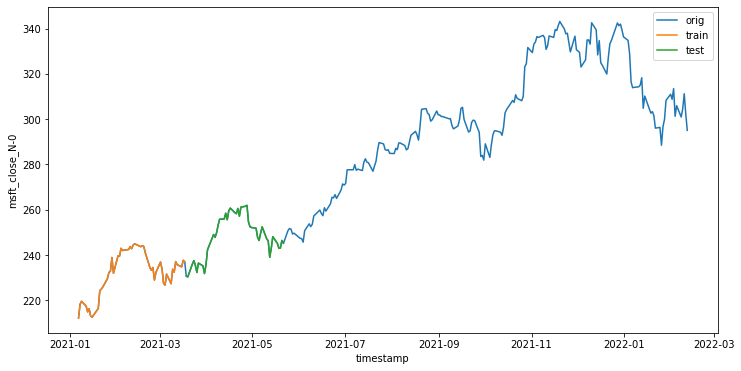

index of train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48]
index of test: [49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]
----------


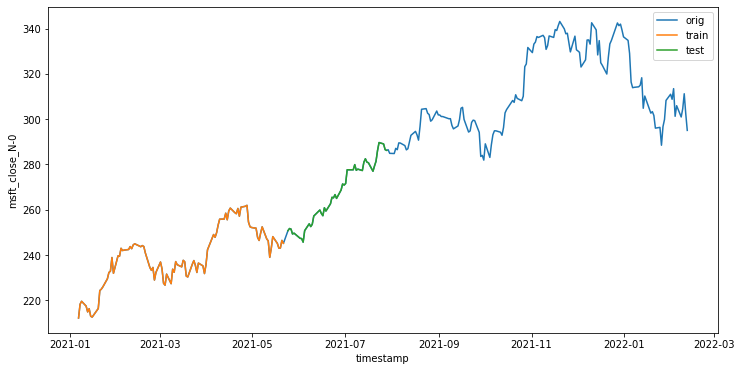

index of train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]
index of test: [ 95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140]
----------


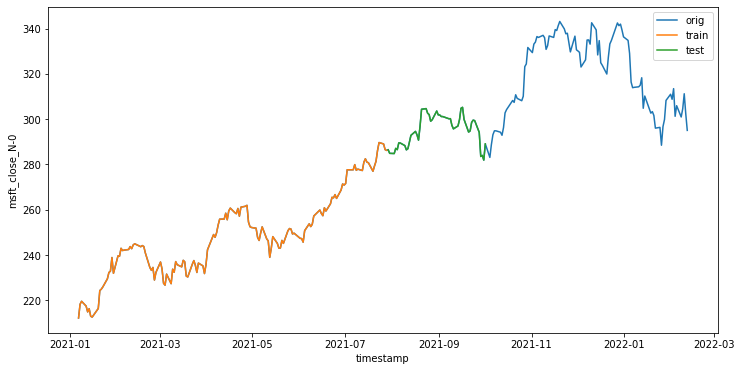

index of train: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140]
index of test: [141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186]
----------


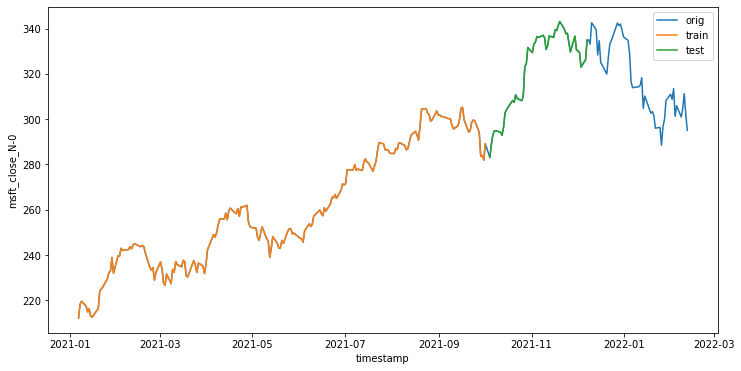

index of train: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186]
index of test: [187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232]
----------


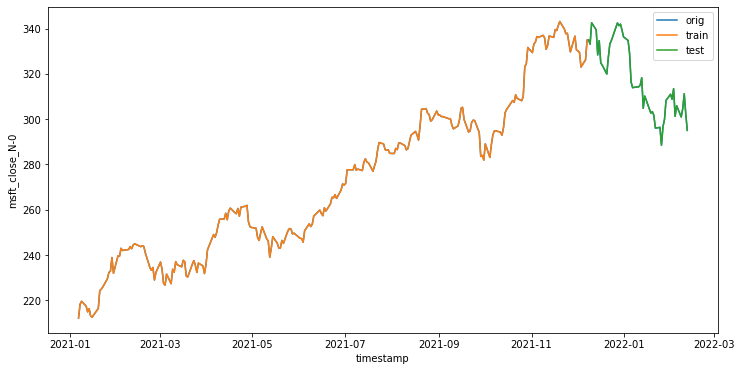

index of train: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232]
index of test: [233 234 235 236 237 23

In [135]:
# NOTE: データセットの分割方法としては、このセルを実行することで表示される5パターンなどが望ましい。
viz_train_test(data, date_time, target)

In [145]:
clfs_lgb, f1_scores_lgb = model.cv_time_series(data, lgb.LGBMClassifier())
print("Average f1 Score（LightGBM）: ", np.mean(f1_scores_lgb))

clfs_lr, f1_scores_lr = model.cv_time_series(data, LogisticRegression(max_iter=1000))
print("Average f1 Score（LogisticRegression）: ", np.mean(f1_scores_lr))

max_ = max(f1_scores_lr)
idx_max = f1_scores_lr.index(max_)
print(f"Adopted Model（Validation{idx_max+1}）:", clfs_lr[idx_max])

Average f1 Score（LightGBM）:  0.27335814283182697
Average f1 Score（LogisticRegression）:  0.4164270477031152
Adopted Model（Validation5）: LogisticRegression(max_iter=1000)
